# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Anomalies Detection using Autoencoders

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### 1. Preparing the data

#### 1.1. Reading data

Read the train dataset  `kddCupTrain.csv` from `kddCupData.zip` and check it for missing values.

In [4]:
kddCupTrain = pd.read_csv('kddCupData/kddCupTrain.csv',header=None)
print("Shape of kddCupTrain: ",kddCupTrain.shape)
print("There are any missing values: ", kddCupTrain.isnull().values.any())
print(kddCupTrain.head(3))

Shape of kddCupTrain:  (985262, 42)
There are any missing values:  False
   0    1     2   3    4      5   6   7   8   9   10  11  12  13  14  15  16  \
0   0  tcp  http  SF  215  45076   0   0   0   0   0   1   0   0   0   0   0   
1   0  tcp  http  SF  162   4528   0   0   0   0   0   1   0   0   0   0   0   
2   0  tcp  http  SF  236   1228   0   0   0   0   0   1   0   0   0   0   0   

   17  18  19  20  21  22  23   24   25   26   27   28   29   30  31  32   33  \
0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0   0   0  0.0   
1   0   0   0   0   0   2   2  0.0  0.0  0.0  0.0  1.0  0.0  0.0   1   1  1.0   
2   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0   2   2  1.0   

    34   35   36   37   38   39   40       41  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  normal.  
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  normal.  
2  0.0  0.5  0.0  0.0  0.0  0.0  0.0  normal.  


The train dataset contains instances of only two class types from the [original](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) data: 
- "normal." - no attack
- "ipsweep." - a subtype of "probe" or Probing Attack type.  

In [5]:
kddCupTrain.iloc[:,-1].unique()

array(['normal.', 'ipsweep.'], dtype=object)

Rename column '41' to 'Class' and transform its values from symbolic type fo binary:  
- "normal." to 0  
- "ipsweep." to 1

In [6]:
kddCupTrain.rename(columns={41:'Class'}, inplace=True)
kddCupTrain['Class'] = np.where(kddCupTrain['Class'] == 'normal.', 0, 1)

Check counts of classes.

In [7]:
count_classes = pd.value_counts(kddCupTrain['Class'], sort = True)
print(count_classes)

0    972781
1     12481
Name: Class, dtype: int64


The dataset is highly imbalanced. Normal connections overwhelmingly outnumber fraudulent ones. 
This suggests using an autoencoder to detect attacks as rare deviations from normal.

#### 1.2. Remove the uninformative columns

Look at summaries of numeric features.

In [8]:
print(kddCupTrain.describe(percentiles=[]))

                   0             4             5              6         7  \
count  985262.000000  9.852620e+05  9.852620e+05  985262.000000  985262.0   
mean      215.078631  1.459258e+03  3.193730e+03       0.000007       0.0   
std      1343.633640  1.097984e+05  3.401613e+04       0.002665       0.0   
min         0.000000  0.000000e+00  0.000000e+00       0.000000       0.0   
50%         0.000000  2.300000e+02  4.060000e+02       0.000000       0.0   
max     58329.000000  8.958152e+07  1.173059e+07       1.000000       0.0   

                   8              9             10             11  \
count  985262.000000  985262.000000  985262.000000  985262.000000   
mean        0.000036       0.048908       0.000097       0.710185   
std         0.015897       0.926008       0.013058       0.453677   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
max        14.000000      77.000000       4.00

Note that some features are constant (min = max and std = 0.0). Such features are not necessary and need to be removed

In [9]:
columnsList = kddCupTrain.columns[kddCupTrain.nunique() <= 1]
kddCupTrain.drop(columnsList, axis=1, inplace=True)
print(kddCupTrain.shape)

(985262, 40)


#### 1.3. Transform symbolic features to "One Hot" columns

Transform character features "1", "2" and "3" into "One Hot" columns using `pandas.get_dummies()` as shown in the section above. 

In [10]:
kddCupTrain = pd.get_dummies(kddCupTrain, columns = [1, 2, 3])
kddCupTrain

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Class,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,0,215,45076,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,162,4528,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,236,1228,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,2,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,233,2032,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,3,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,239,486,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.00,4,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985257,0,212,2288,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,32,0.0,0.0,0.0,0.0,1.0,0.0,0.16,3,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
985258,0,219,236,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,33,0.0,0.0,0.0,0.0,1.0,0.0,0.15,4,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
985259,0,218,3610,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,34,0.0,0.0,0.0,0.0,1.0,0.0,0.15,5,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
985260,0,219,1234,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,35,0.0,0.0,0.0,0.0,1.0,0.0,0.14,6,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


After removing uninformative variables and replacing character variables with hot encoding the dataset contains 83 numeric features.

#### 1.4. Standardize the training dataset

Create a list of features, standardize the features columns using `sklearn.preprocessing.StandardScaler`.

In [11]:
featuresList = [col for col in kddCupTrain if col != 'Class']
scaler = preprocessing.StandardScaler()
scaler.fit(kddCupTrain[featuresList]);
kddCupTrain[featuresList] = scaler.transform(kddCupTrain[featuresList])

In [12]:
print('Mean values:')
print(kddCupTrain[featuresList].mean())
print('\nStd values:')
print(kddCupTrain[featuresList].std(ddof=0))

Mean values:
0              -3.902105e-13
4               2.406711e-15
5               1.810352e-14
6              -3.451193e-14
8              -7.015802e-15
9               4.911297e-14
10              4.875149e-15
11              4.645983e-12
12             -1.404987e-15
13              1.027645e-13
14              3.398800e-14
15             -1.289336e-14
16              1.256161e-14
17              6.611076e-14
18             -8.125271e-14
20             -2.224469e-15
21             -2.329870e-14
22             -1.583833e-13
23              1.341082e-13
24             -7.842140e-14
25              1.218339e-13
26              1.138495e-12
27             -7.429875e-13
28              1.145431e-12
29             -5.408599e-13
30              2.850148e-14
31             -9.426963e-13
32             -4.444883e-13
33              1.611694e-13
34             -1.219637e-12
35              4.962446e-13
36              3.988968e-13
37              1.790377e-13
38              3.115870e-14
3

#### 1.5. Split the data into train and test subsets 

Use `sklearn.model_selection.train_test_split()` function. Reserve 20% of data for the test data. Do not forget to set the parameter `stratify` to keep the class size ratio within each of data sets.

In [13]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 8
X_train_split, X_test_split = train_test_split(kddCupTrain, test_size=0.2, 
                                               stratify=kddCupTrain['Class'], random_state=RANDOM_SEED)

#### 1.6. Detach the labels from the train and the test datasets

In [14]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (788209, 83) , shape Y (788209,)
Test: shape X (197053, 83) , shape Y (197053,)


#### 1.7. Separate the "normal" instances

An autoencoder will be trained to reconstruct class "normal". Separate the "normal" instances in both `train` and `test` datasets.

In [15]:
X_trainNorm_val = X_train[y_train == 0].values # Only values, axis labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data
print(X_trainNorm_val.shape)
print(X_testNorm_val.shape)

(778224, 83)
(194557, 83)


### 2. Build the model

Follow the steps of  `MScA_32017_AMLAI_AE3_FraudDetection.ipynb` to create similar model for this project.

#### 2.1. select architecture of autoencoder

Try different numbers and dimentions of layers. Use `BatchNormalization` and `Dropout` layers to achieve better results.

In [20]:
from sklearn.metrics import mean_squared_error
import h5py
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.optimizers import Adam

Using TensorFlow backend.


In [56]:
# set parameters
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 14
encoder_dim = 7

# create tensors
input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(encoder_dim, activation="relu")(encoder1)
decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)
decoder2 = Dense(input_dim, activation='linear')(decoder1)
print('input_layer: ',input_layer)
print('encoder1',encoder1)
print('encoder2',encoder2)
print('decoder1',decoder1)
print('decoder2',decoder2)

# create autoencoder from the tensors
autoencoder = Model(inputs=input_layer, outputs=decoder2)
autoencoder.summary()

input_layer:  Tensor("input_2:0", shape=(?, 83), dtype=float32)
encoder1 Tensor("dense_5/Tanh:0", shape=(?, 14), dtype=float32)
encoder2 Tensor("dense_6/Relu:0", shape=(?, 7), dtype=float32)
decoder1 Tensor("dense_7/Tanh:0", shape=(?, 14), dtype=float32)
decoder2 Tensor("dense_8/BiasAdd:0", shape=(?, 83), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 83)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 14)                1176      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_7 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_8 (Dense)   

#### 2.2. Fit the model

Fit autoencoder to the "normal" instances of the train dataset. Use `ModelCheckpoint` callback to save the best model.

In [ ]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="autoencoder.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=7, verbose=0) # 'patience' number of not improving epochs
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, scheduler, earlystopping]).history





Train on 778224 samples, validate on 194557 samples
Epoch 1/100





778224/778224 [==============================] - 147s 189us/step - loss: 0.5350 - val_loss: 0.4859
Epoch 2/100
778224/778224 [==============================] - 130s 166us/step - loss: 0.5033 - val_loss: 0.4781
Epoch 3/100
778224/778224 [==============================] - 154s 198us/step - loss: 0.4981 - val_loss: 0.4725
Epoch 4/100
778224/778224 [==============================] - 126s 162us/step - loss: 0.4942 - val_loss: 0.4711
Epoch 5/100
778224/778224 [==============================] - 124s 160us/step - loss: 0.4918 - val_loss: 0.4669
Epoch 6/100
778224/778224 [==============================] - 154s 197us/step - loss: 0.4904 - val_loss: 0.4661
Epoch 7/100
778224/778224 [==============================] - 210s 270us/step - loss: 0.4890 - val_loss: 0.4654
Epoch 8/100
778224/778224 [==============================] - 309s 397us/step - loss: 0.4880 - val_loss: 0.4657
Epoch 9/100
778224/778224 [========================

### 3. Evaluation

#### 3.1. Load the fitted autoencoder from file `"autoencoder.h5"`.

In [21]:
autoencoder = load_model('autoencoder.h5')

Visualize the learning process.

In [24]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

NameError: name 'history' is not defined

#### 3.2.  Reconstruction

Reconstruct the **test** dataset using the fitted autoencoder, calculate the **mean squared error** of the prediction. Calculate MSE of each observation by averaging squared errors of reconstruction of all features in a row.  

In [19]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
print(error_df.head())
print(error_df.reconstruction_error.describe())

        reconstruction_error  true_class
770081              0.139818           0
115728              0.015035           0
930459              0.018690           0
309685              0.065163           0
628397              0.012455           0
count    197053.000000
mean          0.616194
std          27.724412
min           0.000884
25%           0.014870
50%           0.022410
75%           0.072959
max        6022.396884
Name: reconstruction_error, dtype: float64


#### 3.3. Evaluate

Calculate ROC and AUC. 

Tune parameters of autoencoder to achieve better results. Try to make AUC = 0.97 or better to get a good score.

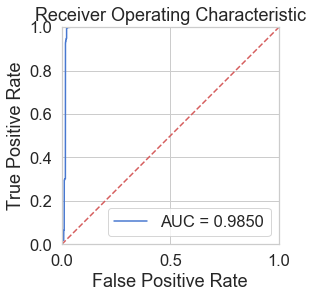

In [28]:
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.axis('square')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Select appropriate quantile and calculate Accuracy and Cohen's Kappa.

In [22]:
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
threshold = normal_error_df.reconstruction_error.quantile(q=0.995)
threshold

2.8308741690887844

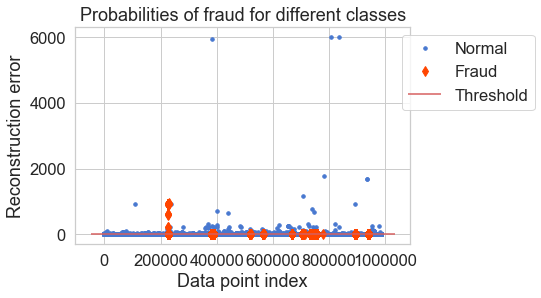

In [27]:
# Plot all errors, normal and fraud cases marked, and the threshold
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    if name == 1:
        MarkerSize = 7
        Color = 'orangered'
        Label = 'Fraud'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(loc='upper left', bbox_to_anchor=(0.95, 1))
plt.title("Probabilities of fraud for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

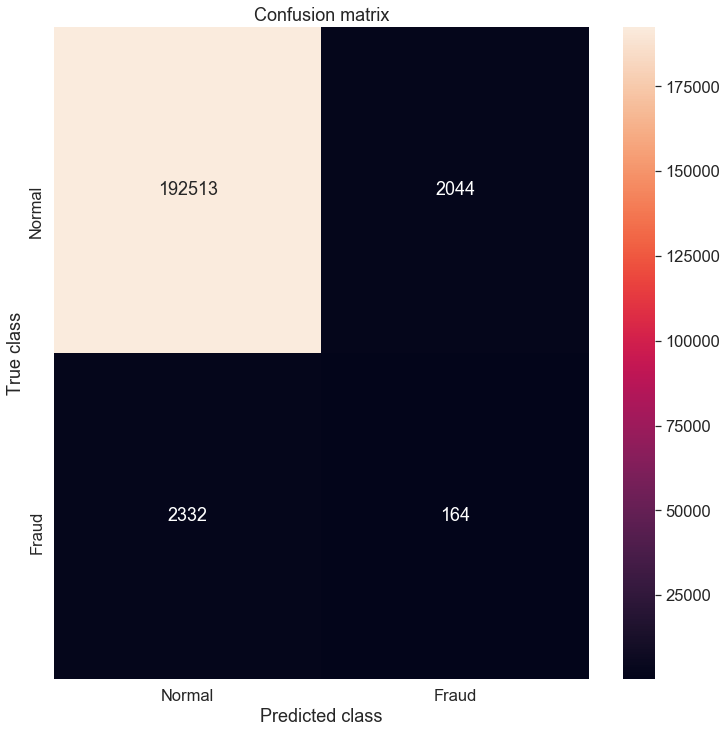

In [26]:
# confusion matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
LABELS = ["Normal", "Fraud"]
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [29]:
cohen_kappa_score(error_df.true_class, y_pred),accuracy_score(error_df.true_class, y_pred)

(0.058532778046856526, 0.9777927765626506)


### 4.Create submission

#### 4.1. Read test data

Read the **test** dataset from ['kddCupTest.csv'](kddCupTest.csv) and check it for missing values.  

In [13]:
kddCupTest = pd.read_csv('kddCupData/kddCupTest.csv', header=None)
print(kddCupTest.head(3))

   0    1        2   3     4      5   6   7   8   9   10  11  12  13  14  15  \
0   0  tcp     http  SF   230  10066   0   0   0   0   0   1   0   0   0   0   
1   0  udp  private  SF   105    145   0   0   0   0   0   0   0   0   0   0   
2   1  tcp     smtp  SF  1888    374   0   0   0   0   0   1   0   0   0   0   

   16  17  18  19  20  21  22  23   24   25   26   27   28   29   30   31  \
0   0   0   0   0   0   0  19  20  0.0  0.0  0.0  0.0  1.0  0.0  0.1  255   
1   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   
2   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   

    32    33    34   35   36   37   38   39   40  
0  255  1.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  
1  227  0.89  0.01  0.0  0.0  0.0  0.0  0.0  0.0  
2  174  0.68  0.03  0.0  0.0  0.0  0.0  0.0  0.0  


Notice that there are no lables in the test dataset. The features columns are the same.

#### 4.2. Do "One hot" transformation of categorical features

Don't forget to make the features list exactly the same as in the **train** dataset.

In [14]:
# remove the same columns as for training set
kddCupTest.drop(columnsList, axis=1, inplace=True)
print(kddCupTest.shape)
# one hot encoding of the three categorical features
kddCupTest = pd.get_dummies(kddCupTest, columns = [1, 2, 3])
print(kddCupTest.shape)

(196557, 39)
(196557, 106)


To get the same set of columns add the missing columns of the train set with zero values and drop the extra columns that were not included in the train set.

In [15]:
missing_cols = set(kddCupTrain.columns) - set(kddCupTest.columns)
print('missing_cols: ', missing_cols)
for c in missing_cols:
    kddCupTest[c] = 0
# drop the extra columns that were not in training set
kddCupTest = kddCupTest[kddCupTrain.columns].copy()
# drop the Class column that was created for the test set by the previous steps
kddCupTest.drop(columns='Class', inplace=True)
kddCupTest

missing_cols:  {'2_tftp_u', 'Class', '3_SH'}


,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,0,230,10066,0,0,0,0,1,0,0,0,0,0,0,0,0,0,19,20,0.0,0.0,0.0,0.0,1.0,0.0,0.10,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,227,0.89,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,1888,374,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,174,0.68,0.03,0.00,0.00,0.00,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,330,1477,0,0,0,0,1,0,0,0,0,0,0,0,0,0,9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.00,94,255,1.00,0.00,0.01,0.03,0.01,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2625,146,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0.0,0.0,0.0,0.0,0.5,0.5,0.00,255,2,0.01,0.87,1.00,0.00,0.00,0.0,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196552,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,1.0,1.0,0.0,0.00,5,255,1.00,0.00,0.20,0.25,0.00,0.0,1.0,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
196553,0,146,5532,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,24,0.0,0.0,0.0,0.0,1.0,0.0,0.12,1,255,1.00,0.00,1.00,0.02,0.00,0.0,0.0,0.01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
196554,0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,245,0.96,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
196555,0,267,14496,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7,7,0.0,0.0,0.0,0.0,1.0,0.0,0.00,56,255,1.00,0.00,0.02,0.03,0.00,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Notice that there are no lables in the test dataset. The features columns are the same.

#### 4.3. Standardize the test dataset

Use the scaler fitted to the training dataset.

In [16]:
kddCupTest[featuresList] = scaler.transform(kddCupTest[featuresList])
kddCupTest

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,-0.160072,-0.011196,0.202030,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,0.619084,0.413940,-0.054177,-0.065379,-0.244638,-0.247100,0.157516,-0.156700,-0.136523,1.041395,0.613042,0.505148,-0.312768,-0.490601,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.241500,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
1,-0.160072,-0.012334,-0.089626,-0.002665,-0.002235,-0.052816,-0.007462,-1.565399,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.247100,0.157516,-0.156700,-0.486674,1.041395,0.292613,0.144414,-0.257618,-0.490601,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,-1.889026,2.036924,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,-1.300185,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,3.495030,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.241500,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
2,-0.159328,0.003905,-0.082894,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.247100,0.157516,-0.156700,-0.486674,1.041395,-0.313915,-0.544261,-0.147318,-0.490601,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,-1.300185,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,3.054411,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.241500,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
3,-0.160072,-0.010285,-0.050468,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,0.052756,-0.091819,-0.054177,-0.065379,-0.244638,-0.247100,0.157516,-0.156700,-0.486674,-0.506306,0.613042,0.505148,-0.312768,-0.456771,-0.019122,0.281637,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.241500,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
4,1.793586,-0.011961,-0.090802,-0.002665,-0.002235,-0.052816,-0.007462,-1.565399,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.230408,-0.413666,-0.054177,-0.065379,-0.244638,-0.247100,-5.251171,4.122919,-0.486674,1.041395

In [17]:
print('Mean values:')
print(kddCupTest[featuresList].mean())
print('\nStd values:')
print(kddCupTest.std(ddof=0))

Mean values:
0               0.001532
4              -0.001717
5               0.000514
6              -0.002665
8              -0.000634
9              -0.000375
10             -0.000838
11              0.003580
12             -0.002448
13             -0.001816
14             -0.003311
15             -0.002509
16             -0.000906
17             -0.000380
18             -0.002493
20             -0.001425
21             -0.002248
22              0.250588
23             -0.007380
24              0.025350
25              0.029340
26              0.041149
27              0.041792
28             -0.108134
29              0.085014
30             -0.026512
31              0.024516
32             -0.016654
33             -0.031113
34              0.048219
35             -0.035182
36             -0.086187
37              0.023180
38              0.044683
39              0.038789
40              0.043377
1_icmp         -0.072195
1_tcp           0.028178
1_udp          -0.001137
2_IRC       

#### 4.4. Make predictions and save the results to csv file.

Reconstruct the **kddCupTest** dataset, calculate **mean squared error** as reconstruction error.  
Save MSE to scv file. 

`result_df = pd.DataFrame({'reconstruction_error': testMSE})
 result_df.to_csv('filename.csv')`

The format should be as follows:  
  
,reconstruction_error  
0,0.019312
1,0.049165
2,0.084997 

In [23]:
kddCupTestPredictions = autoencoder.predict(kddCupTest)
kddCupTestMSE = mean_squared_error(kddCupTest.transpose(), kddCupTestPredictions.transpose(),
                              multioutput='raw_values')
result_df = pd.DataFrame({'reconstruction_error': kddCupTestMSE})
print(result_df.head())
print(result_df.reconstruction_error.describe())
result_df.to_csv('result1.csv')

   reconstruction_error
0              0.014865
1              0.013142
2              0.087581
3              0.005694
4              0.056208
count    196557.000000
mean          0.620900
std          18.441707
min           0.000842
25%           0.014868
50%           0.022438
75%           0.072563
max        3969.751547
Name: reconstruction_error, dtype: float64


#### 4.5. Upload the results

Upload the saved file using [shiny test application](https://shiny.ilykei.com/courses/AdvancedML/AutoEncoder).
The uploaded results will be used for calculation of AUC. The goal for this project is to get AUC not less then 0.97.
